# FACE-MASK DETECTION

In [1]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import cv2
import pathlib
import random

In [2]:
data_path='Face Mask Dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'WithMask': 0, 'WithoutMask': 1}
['WithMask', 'WithoutMask']
[0, 1]


In [3]:
img_size=128
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 128x128, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next imag

In [4]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [5]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [6]:
np.save('data',data)
np.save('target',new_target)

In [7]:
data=np.load('data.npy')
target=np.load('target.npy')

In [8]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1,random_state=21)

In [7]:
model10=keras.models.Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=data.shape[1:]),
    MaxPooling2D(pool_size=(4,4),strides=(4,4)),
    Dropout(0.25),
    
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Flatten(),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(128,activation='relu'),
    Dense(2,activation='sigmoid')

])

In [8]:
model10.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        3

In [10]:
model10.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
callbacks=[ReduceLROnPlateau(monitor='loss',facotr=0.5,patience=5,min_lr=0.001)]

history=model10.fit_generator(aug.flow(train_data,train_target,batch_size=32),epochs=50,verbose=1,validation_data=(test_data,test_target),callbacks=callbacks)

Epoch 1/50
306/306 [==============================] - 74s 242ms/step - loss: 0.4530 - accuracy: 0.7594 - val_loss: 0.1361 - val_accuracy: 0.9576
Epoch 2/50
306/306 [==============================] - 72s 236ms/step - loss: 0.1232 - accuracy: 0.9550 - val_loss: 0.0672 - val_accuracy: 0.9800
Epoch 3/50
306/306 [==============================] - 81s 264ms/step - loss: 0.0885 - accuracy: 0.9675 - val_loss: 0.0574 - val_accuracy: 0.9788
Epoch 4/50
306/306 [==============================] - 82s 267ms/step - loss: 0.0744 - accuracy: 0.9727 - val_loss: 0.0506 - val_accuracy: 0.9859
Epoch 5/50
306/306 [==============================] - 79s 258ms/step - loss: 0.0639 - accuracy: 0.9769 - val_loss: 0.0672 - val_accuracy: 0.9764
Epoch 6/50
306/306 [==============================] - 79s 258ms/step - loss: 0.0641 - accuracy: 0.9770 - val_loss: 0.0445 - val_accuracy: 0.9847
Epoch 7/50
306/306 [==============================] - 81s 264ms/step - loss: 0.0560 - accuracy: 0.9788 - val_loss: 0.0416 - val_ac

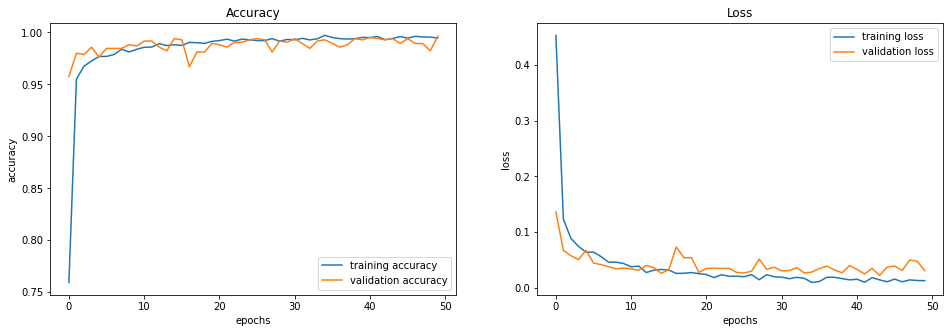

In [12]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16,5))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [13]:
model10.evaluate(test_data, test_target, verbose=2)
predict = (model10.predict(test_data) > 0.5).astype("int32")
print(classification_report(test_target,predict))
#print(confusion_matrix(test_target,predict))
testtgt = np.argmax(test_target,axis = 1)
pred = np.argmax(predict,axis = 1)
print(confusion_matrix(testtgt,pred))

37/37 - 2s - loss: 0.0227 - accuracy: 0.9941
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       608
           1       0.99      1.00      0.99       572

   micro avg       0.99      0.99      0.99      1180
   macro avg       0.99      0.99      0.99      1180
weighted avg       0.99      0.99      0.99      1180
 samples avg       0.99      0.99      0.99      1180

[[602   6]
 [  1 571]]


In [14]:
print('Accuracy:', accuracy_score(test_target, predict))

Accuracy: 0.9940677966101695


In [17]:
from sklearn import metrics
y_pred_proba = model10.predict_proba(test_data)
y_pred_proba=np.argmax(y_pred_proba,axis = 1)
test_target=np.argmax(test_target,axis=1)
fpr, tpr, threshold = metrics.roc_curve(test_target, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

Instructions for updating:
Please use `model.predict()` instead.


0.9941916635995585

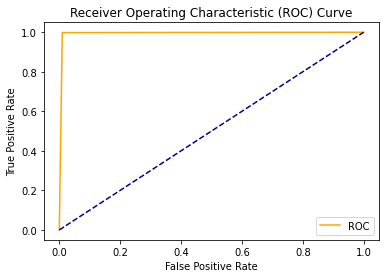

In [18]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_cur(fpr, tpr)

In [19]:
model10.save("model10.h5")

In [20]:
model10.save("model10.model", save_format="h5")

In [21]:
model10.save("model10")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model10\assets


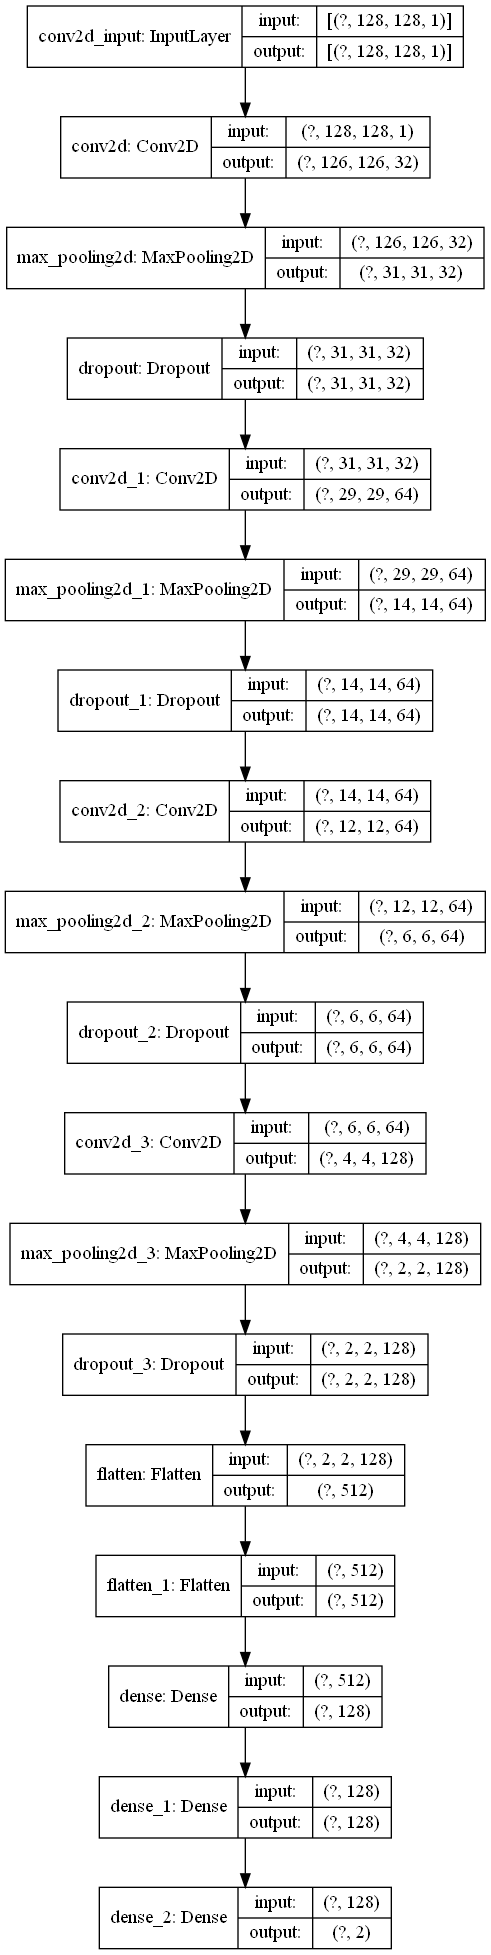

In [25]:
plot_model(model10,show_shapes=True,show_layer_names=True)

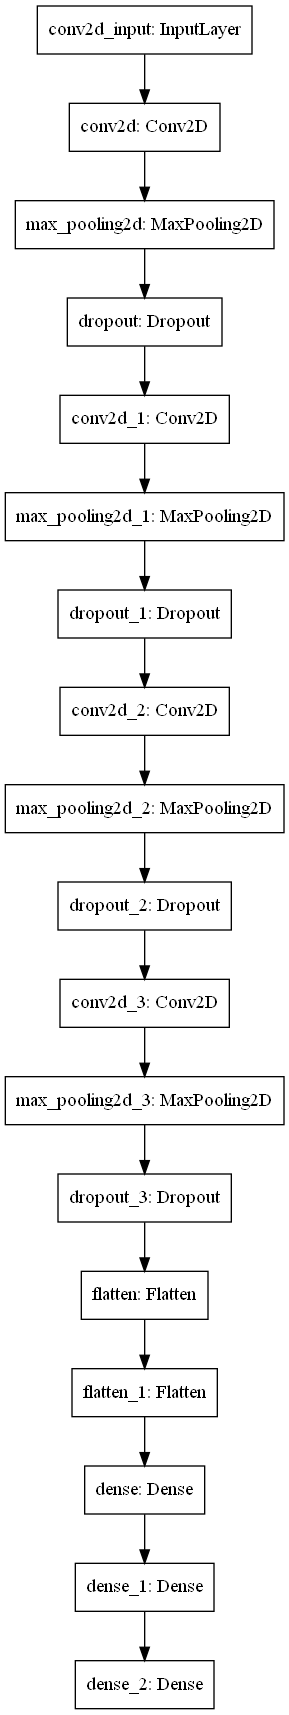

In [26]:
tf.keras.utils.plot_model(
    model10,
    to_file="model6.png",
    show_shapes=False,
    #show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,)

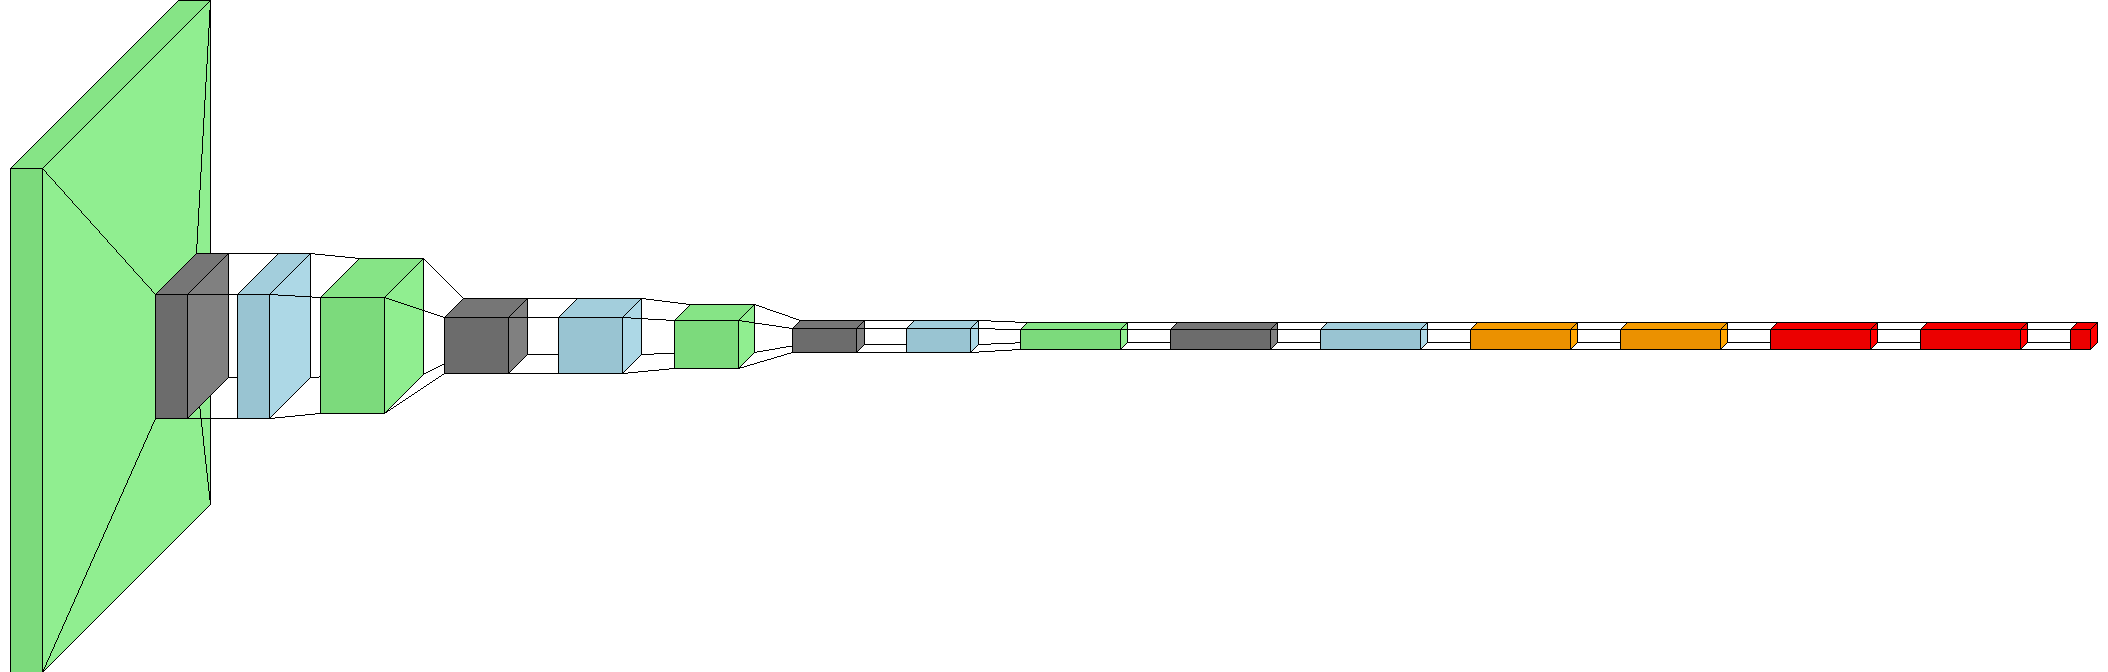

In [27]:
import visualkeras
import collections

color_map = collections.defaultdict(dict)
color_map[Conv2D]['fill'] = 'lightgreen'
color_map[Dropout]['fill'] = "lightblue"
color_map[MaxPooling2D]['fill'] = 'gray'
color_map[Dense]['fill'] = 'red'
color_map[Flatten]['fill'] = 'orange'

visualkeras.layered_view(model10, spacing=50,color_map=color_map,scale_xy=4, scale_z=1, max_z=100)